<h1 align="center">ENGC63 - 3º Projeto</h1>

**Universidade Federal da Bahia - UFBA**

**Disciplina :** Processamento Digital de Sinais

**Discentes :** Miguel Feliciano Mota Alves e Rodrigo Freitas Sá Barretto

## Introdução

A janela de kaiser é definida por:

$$
w[n] = 
\begin{cases}
\displaystyle
\frac{I_0[\beta(1-[\frac{(n-\alpha)}{\alpha}]^2)^{1/2}]}{I_0(\beta)}\\
0, & \text{caso contrário}
\end{cases}
$$

onde $\alpha = M/2$ e $I_0(\cdot)$ é a função de Besel modificada.

Para implementar o filtro FIR utilizando a **janela de Kaiser**, diferentemente dos outros tipos de janela, primeiro define-se as especificações do filtro desejado e, com as especificações definidas, calcula-se os parâmetros da janela $\beta$ e $M$ da janela.

## Dados do Projeto

A seguir estão as especificações definidas para o projeto do filtro.

### 1. Especificações de Frequência

Com uma frequência de corte central ($\omega_c$) e uma largura de banda de transição ($\Delta\omega$) definidas, as frequências da banda de passagem ($\omega_p$) e da banda de rejeição ($\omega_s$) podem ser encontradas a partir delas.

* **Frequência de Corte Central ($\omega_c$):**
    $$\omega_c = \frac{\pi}{2} \text{ rad/amostra}$$

* **Largura da Banda de Transição ($\Delta\omega$):**
    $$\Delta\omega = 0.1\pi \text{ rad/amostra}$$

* **Banda de Passagem:** O filtro deve passar frequências no intervalo $[0, \omega_p]$, $\omega_p = \omega_c - (\Delta\omega/2)$.
    $$0 \le \omega \le 0.45\pi \text{ rad/amostra}$$

* **Banda de Rejeição:** O filtro deve rejeitar frequências no intervalo $[\omega_s, \pi]$, $\omega_s = \omega_c + (\Delta\omega/2)$, até $\pi$.
    $$0.55\pi \le \omega \le \pi \text{ rad/amostra}$$

### 2. Ripple e Atenuação

Como, para o projeto por janela, o filtro resultante terá o mesmo erro de pico na banda de passagem e na banda de rejeição, isto é, $\delta_p = \delta_s$ e a atenuação na banda de rejeição pode ser definida por:

$$A_s = -20 \log_{10}(|H(e^{j\omega})|) \ge 50 \text{ dB}$$

portanto:

$$\delta_p = \delta_s \approx 0.00316$$

### 3. Intervalos de Tolerância

Com base nas especificações de frequência e nos valores de *ripple* definidos, os intervalos de tolerância para a magnitude da resposta em frequência, $|H(e^{j\omega})|$, são os seguintes:

* **Na Banda de Passagem ($0 \le \omega \le 0.45\pi$):** O ganho deve estar dentro do seguinte intervalo: 
    $$0.99684 \le |H(e^{j\omega})| \le 1.00316$$

* **Na Banda de Rejeição ($0.55\pi \le \omega \le \pi$):** O ganho deve ser suprimido para o seguinte intervalo:
    $$ 0 \le |H(e^{j\omega})| \le 0.00316$$

In [411]:
from scipy.signal import kaiserord, firwin, freqz, tf2sos, sosfreqz, sosfilt
from numpy import pi, log10, abs, arange, where, zeros
import matplotlib.pyplot as plt

In [412]:
w_cutoff = pi / 2                  # Frequência de corte [rad/amostra]
w_transition = 0.1 * pi            # Região de transição [rad/amostra]
A = 50                                # Atenuação [dB]
w_pass = w_cutoff - w_transition/2    # Banda de passagem [rad/amostra]
w_stop = w_cutoff + w_transition/2    # Banda de rejeição [rad/amostra]
erro = 0.00316                        # Erro máximo

print(f"Frequência de corte: {w_cutoff/pi}π")
print(f"Região de transição: {w_transition/pi}π")
print(f"Banda de passagem: {w_pass/pi}π")
print(f"Banda de rejeição: {w_stop/pi}π")
print(f"Atenuação: {A} dB")
print(f"Erro máximo: {erro}")

Frequência de corte: 0.5π
Região de transição: 0.1π
Banda de passagem: 0.45π
Banda de rejeição: 0.55π
Atenuação: 50 dB
Erro máximo: 0.00316


In [413]:
M, beta = kaiserord(A, w_transition / pi) # Calcula a ordem e o beta da janela kaiser
print(f"Ordem do filtro: {M}")
print(f"β = {beta}")

Ordem do filtro: 60
β = 4.533514120981248


Para este projeto, a ordem escolhida do filtro será PAR, para que o filtro projetado seja de tipo 1 e não imponha restrições. Isso é essencial para uma etapa futura do trabalho, onde serão feitas transformações do filtro passa-baixas para outros tipos de filtro (e.g. passa-altas). Se outros tipos de filtro fossem utilizados, as restrições existentes para esses tipos poderiam levar a resultados indesejados.

In [414]:
'''
1 - numtaps = Ordem(FIR) + 1, se M é par, numtaps é impar
2 - Cria o filtro usando a janela Kaiser
3 - Cutoff precisa ser normalizado
4 - Por padrão a biblioteca scipy implementa o filtro na forma direta
''' 
fir_direct = firwin(numtaps=M+1, cutoff=w_cutoff / pi, window=("kaiser", beta), pass_zero="lowpass")

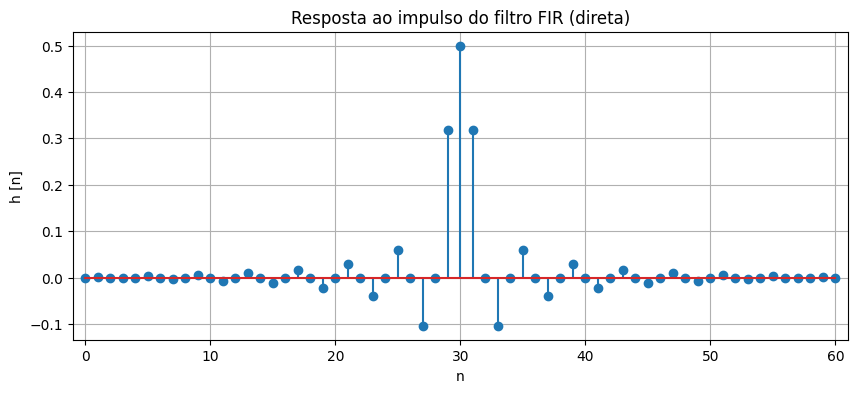

In [415]:
plt.figure(figsize=(10, 4))
plt.stem(arange(len(fir_direct)), fir_direct)
plt.title('Resposta ao impulso do filtro FIR (direta)')
plt.xlabel('n')
plt.ylabel('h [n]')
xlim = [-1, 61]
plt.xlim(xlim)
plt.grid(True)
plt.show()

Como esperado do filtro passa-baixas (tipo I) projetado, a resposta ao impulso do filtro projetado se aproxima de uma função sinc, com comprimento $M + 1$, com simetria par e centrada em $M/2$

In [416]:
omega_direct, response_direct = freqz(fir_direct, worN=2048) # Calcula resposta do filtro na forma direta
omega_direct_norm = omega_direct / pi                        # Normaliza a frequência para o intervalo [0, 1]
fir_direct_mag = abs(response_direct)                        # |H(e^jw)|
responde_direct_dB = 20 * log10(abs(response_direct))        # Resposta em dB



In [417]:
# Cria um filtro passa-baixas ideal para comparação e cálculo de erro
lpf_ideal = where(omega_direct_norm <= w_cutoff / pi, 1.0, 0.0) 

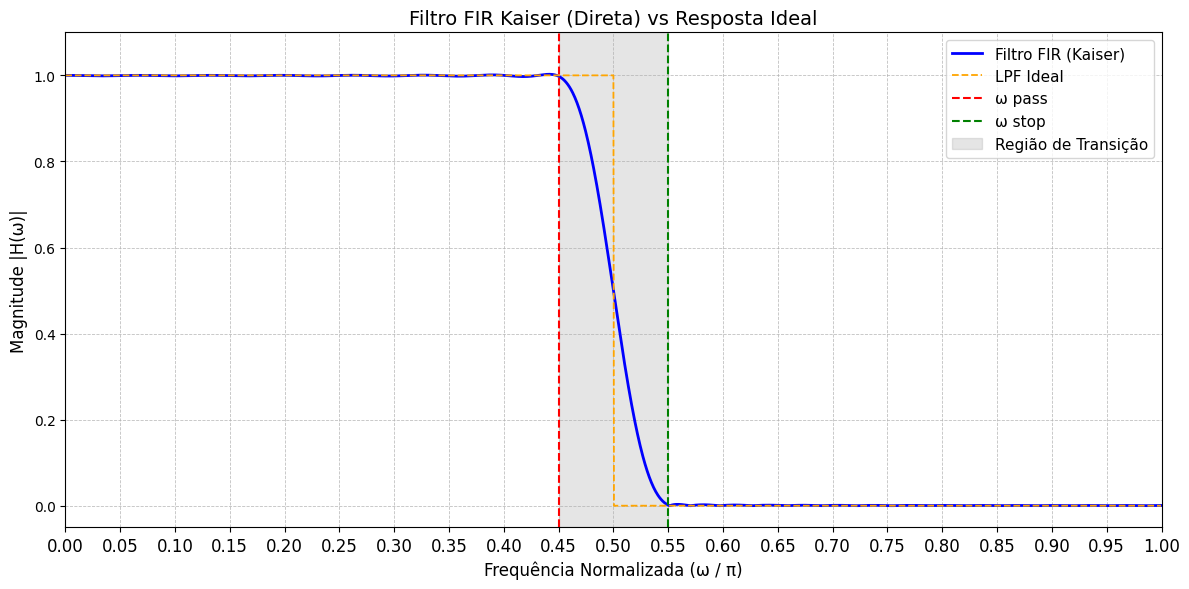

In [418]:
plt.figure(figsize=(12, 6))

plt.plot(omega_direct_norm, fir_direct_mag, label="Filtro FIR (Kaiser)", color='blue', linewidth=2)
plt.plot(omega_direct_norm, lpf_ideal, color="orange", linestyle="--", linewidth=1.3, label="LPF Ideal")
plt.axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
plt.axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
plt.axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
plt.title('Filtro FIR Kaiser (Direta) vs Resposta Ideal', fontsize=14)
plt.xlabel('Frequência Normalizada (ω / π)', fontsize=12)
plt.ylabel('Magnitude |H(ω)|', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.8)
plt.legend(fontsize=11)
plt.xticks(arange(0, 1.05, 0.05), fontsize=12)
plt.xlim(0, 1.0)
plt.ylim(-0.05, 1.1)
plt.tight_layout()
plt.show()


É possível observar que, ao utilizar o projeto por janela de Kaiser, tanto a banda passante quanto a banda de rejeição apresentam oscilações características. Esse comportamento está relacionado à limitação prática de não ser possível somar uma quantidade infinita de senoides na representação por séries de Fourier. Esse efeito é conhecido como fenômeno de Gibbs e é esperado para projetos de filtros que utilizando o janelamento.

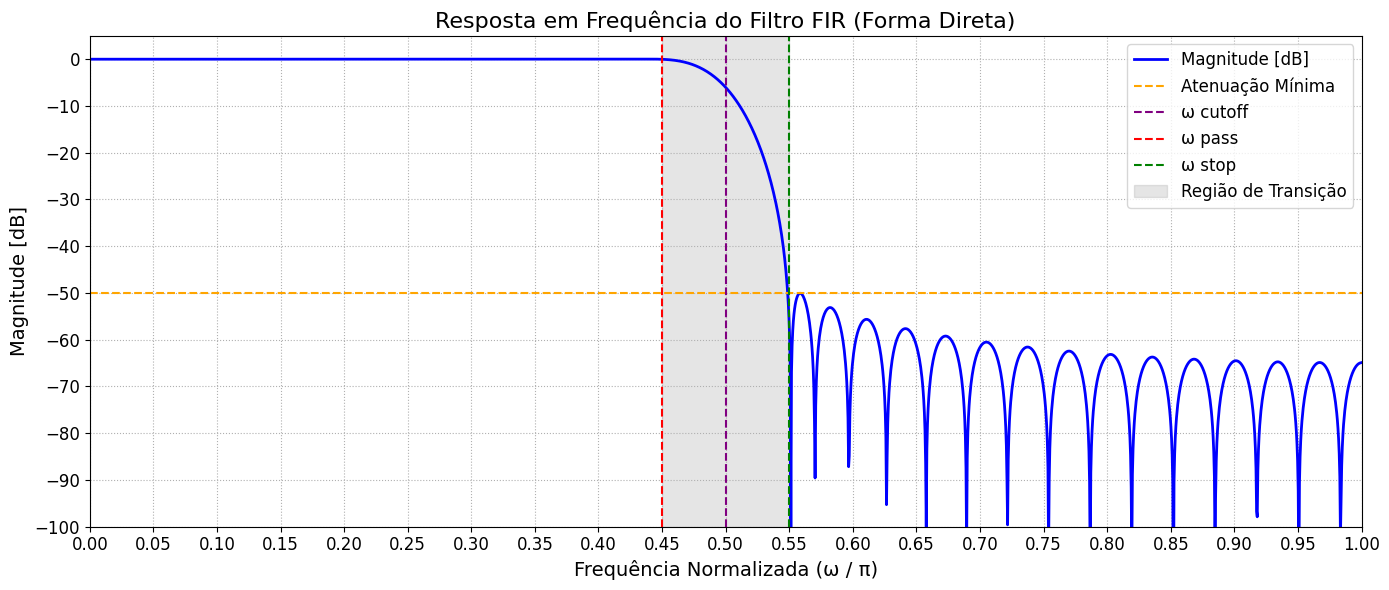

In [419]:
plt.figure(figsize=(14, 6))
plt.plot(omega_direct_norm, responde_direct_dB, color='blue', linewidth=2, label='Magnitude [dB]')
plt.title('Resposta em Frequência do Filtro FIR (Forma Direta)', fontsize=16)
plt.xlabel('Frequência Normalizada (ω / π)', fontsize=14)
plt.ylabel('Magnitude [dB]', fontsize=14)
plt.xticks(arange(0, 1.05, 0.05), fontsize=12)
plt.yticks(arange(-100, 10, 10), fontsize=12)
plt.ylim(-100, 5)
plt.xlim(0, 1.0)
plt.axhline(-50, color='orange', linestyle='--', linewidth=1.5, label='Atenuação Mínima')
plt.axvline(0.50, color='purple', linestyle='--', linewidth=1.5, label='ω cutoff')
plt.axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
plt.axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
plt.axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
plt.grid(True, which='both', linestyle=':', linewidth=0.8)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()


Para a resposta em frequência, fica evidente que, ao atingir a frequência de corte, o filtro está com uma atenuação de 50 dB. Além disso, também é possível perceber que os outros requisitos como largura da banda passante, da região de transição e outros também está sendo cumprida.

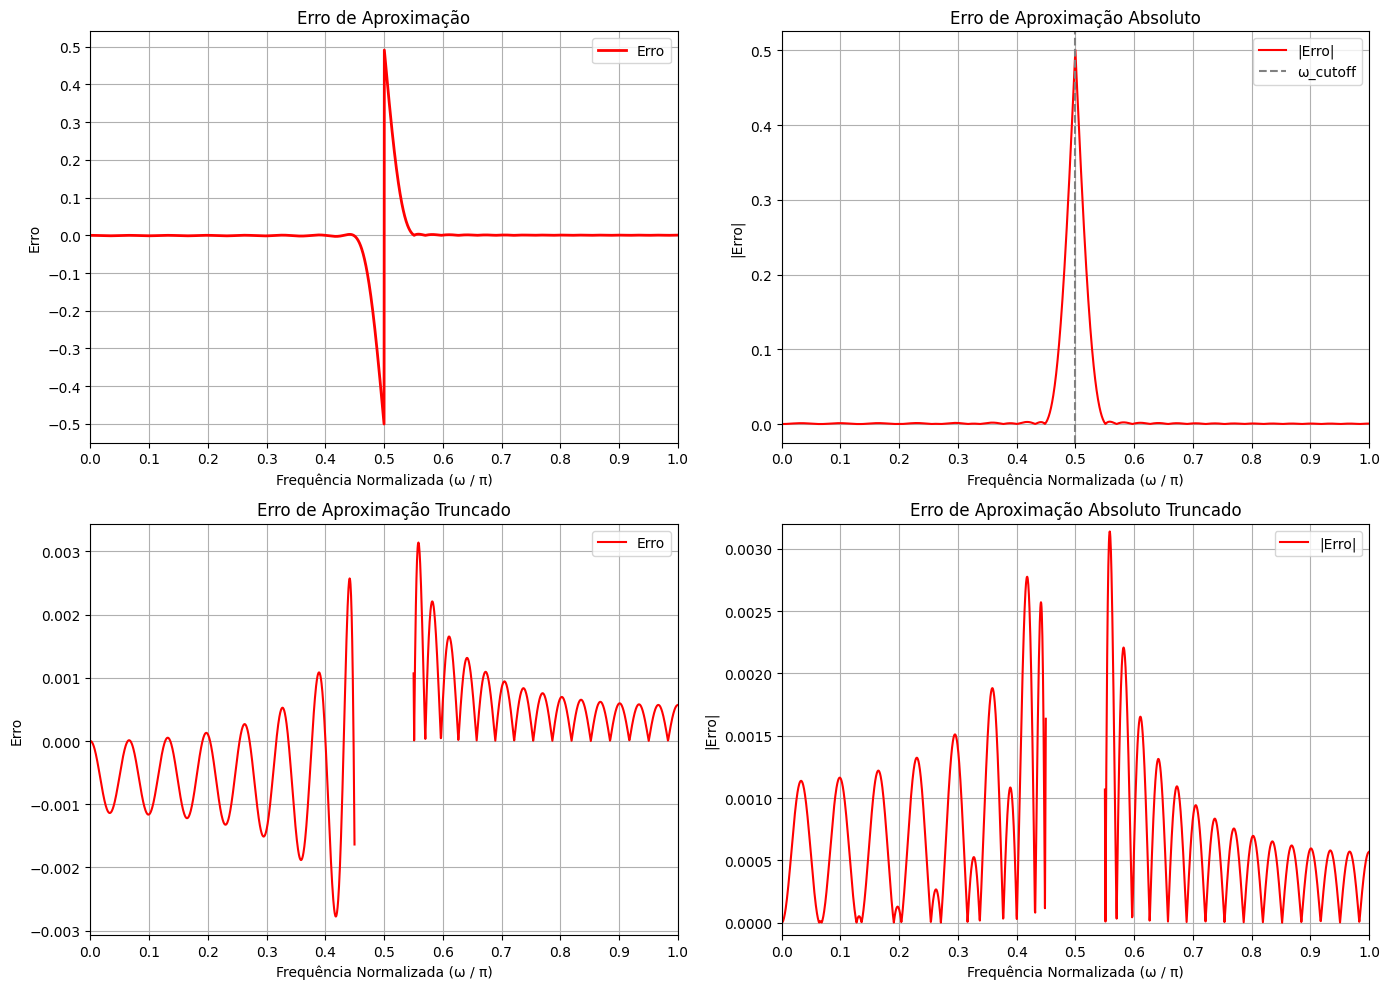

In [425]:
# Erro de aproximação = H(ω) - LPF(ω)
erro = fir_direct_mag - lpf_ideal

# Erro de aproximação absoluto = |H(ω) - LPF(ω)|
erro_abs = abs(fir_direct_mag - lpf_ideal)

# Arrays de bools para truncar a resposta na faixa de transição
truncate_pass = omega_direct_norm <= w_pass / pi
truncate_stop = omega_direct_norm >= w_stop / pi

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Transforma a matriz 2x2 em um vetor de 4 elementos

# Gráfico 1: Erro de aproximação
axes[0].plot(omega_direct_norm, erro, color='red', linewidth=2, label='Erro')
axes[0].set_title('Erro de Aproximação')
axes[0].set_xlabel('Frequência Normalizada (ω / π)')
axes[0].set_ylabel('Erro')
axes[0].set_xticks(arange(0, 1.1, 0.1))
axes[0].set_yticks(arange(-0.5, 0.6, 0.1))
axes[0].set_xlim(0, 1.0)
axes[0].grid(True)
axes[0].legend()

# Gráfico 2: Erro absoluto de aproximação
axes[1].plot(omega_direct_norm, erro_abs, color='red', linewidth=1.5, label='|Erro|')
axes[1].axvline(w_cutoff / pi, color='grey', linestyle='--', label='ω_cutoff')
axes[1].set_title('Erro de Aproximação Absoluto')
axes[1].set_xlabel('Frequência Normalizada (ω / π)')
axes[1].set_ylabel('|Erro|')
axes[1].set_xticks(arange(0, 1.1, 0.1))
axes[1].set_xlim(0, 1.0)
axes[1].grid(True)
axes[1].legend()

# Gráfico 3: Erro de aproximação sem o pico para melhor visualização
axes[2].plot(omega_direct_norm[truncate_pass], erro[truncate_pass], color='red', linewidth=1.5, label='Erro')
axes[2].plot(omega_direct_norm[truncate_stop], erro[truncate_stop], color='red', linewidth=1.5)
axes[2].set_title('Erro de Aproximação Truncado')
axes[2].set_xlabel('Frequência Normalizada (ω / π)')
axes[2].set_ylabel('Erro')
axes[2].set_xlim(0, 1.0)
axes[3].set_ylim(-0.0032, 0.0032)
axes[2].set_xticks(arange(0, 1.1, 0.1))
axes[2].grid(True)
axes[2].legend()

# Gráfico 4:  Erro de aproximação absoluto sem o pico para melhor visualização
axes[3].plot(omega_direct_norm[truncate_pass], erro_abs[truncate_pass], color='red', linewidth=1.5, label='|Erro|')
axes[3].plot(omega_direct_norm[truncate_stop], erro_abs[truncate_stop], color='red', linewidth=1.5)
axes[3].set_title('Erro de Aproximação Absoluto Truncado')
axes[3].set_xlabel('Frequência Normalizada (ω / π)')
axes[3].set_ylabel('|Erro|')
axes[3].set_xlim(0, 1.0)
axes[3].set_ylim(-0.0001, 0.0032)
axes[3].set_xticks(arange(0, 1.1, 0.1))
axes[3].grid(True)
axes[3].legend()

plt.tight_layout()
plt.show()




Como esperado, o erro máximo de aproximação não excede o valor de $\delta_s$ previamente especificado, nem para a banda de passagem nem para a banda de rejeição. Observa-se também que o pico do erro ocorre em $\omega_c$, o que era previsto, dado que nesse ponto o filtro ideal do tipo passa-baixas apresenta uma descontinuidade (i.e. ele muda abruptamente de 1 para 0). Já o filtro projetado com a janela de Kaiser gera uma transição contínua, resultando em um desvio mais pronunciado exatamente nessa frequência.


In [421]:
# Constrói o filtro usando a forma em cascata
fir_cascate = tf2sos(fir_direct, [1.0])

omega_cascate, response_cascate = sosfreqz(fir_cascate, worN=2048) # Calcula resposta do filtro em cascata
omega_cascate_norm = omega_cascate / pi                            # Normaliza a frequência para o intervalo [0, 1]
fir_cascate_mag = abs(response_cascate)                             # |H(e^jw)|
response_cascate_dB = 20 * log10(abs(response_cascate))                    # Resposta em dB

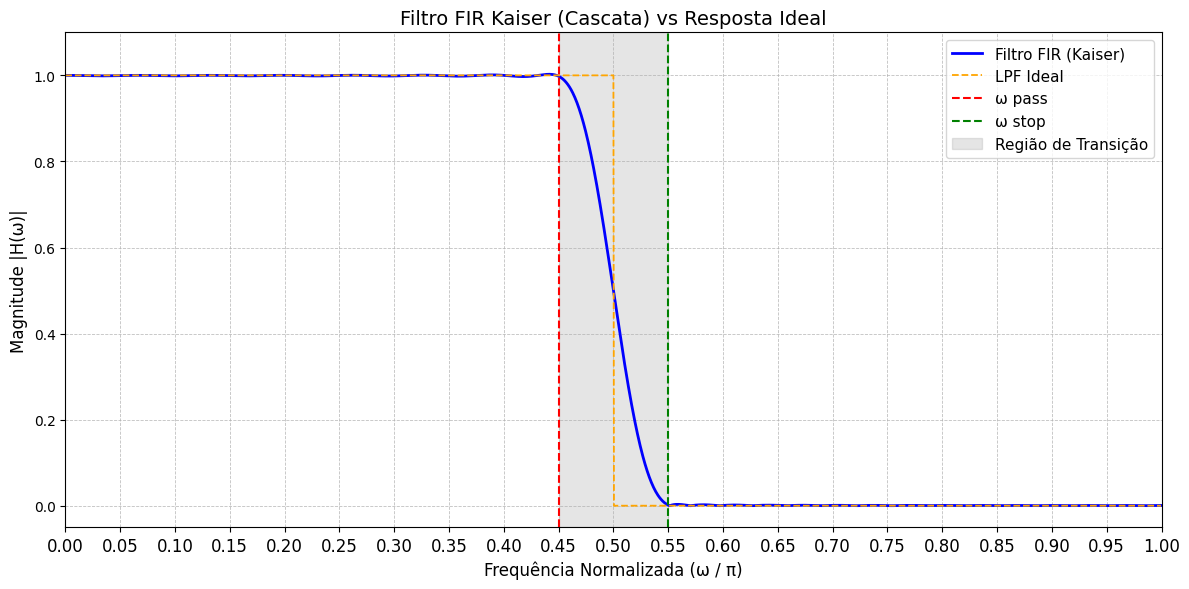

In [422]:
plt.figure(figsize=(12, 6))

plt.plot(omega_direct_norm, fir_cascate_mag, label="Filtro FIR (Kaiser)", color='blue', linewidth=2)
plt.plot(omega_direct_norm, lpf_ideal, color="orange", linestyle="--", linewidth=1.3, label="LPF Ideal")
plt.axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
plt.axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
plt.axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
plt.title('Filtro FIR Kaiser (Cascata) vs Resposta Ideal', fontsize=14)
plt.xlabel('Frequência Normalizada (ω / π)', fontsize=12)
plt.ylabel('Magnitude |H(ω)|', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.6, alpha=0.8)
plt.legend(fontsize=11)
plt.xticks(arange(0, 1.05, 0.05), fontsize=12)
plt.xlim(0, 1.0)
plt.ylim(-0.05, 1.1)
plt.tight_layout()
plt.show()

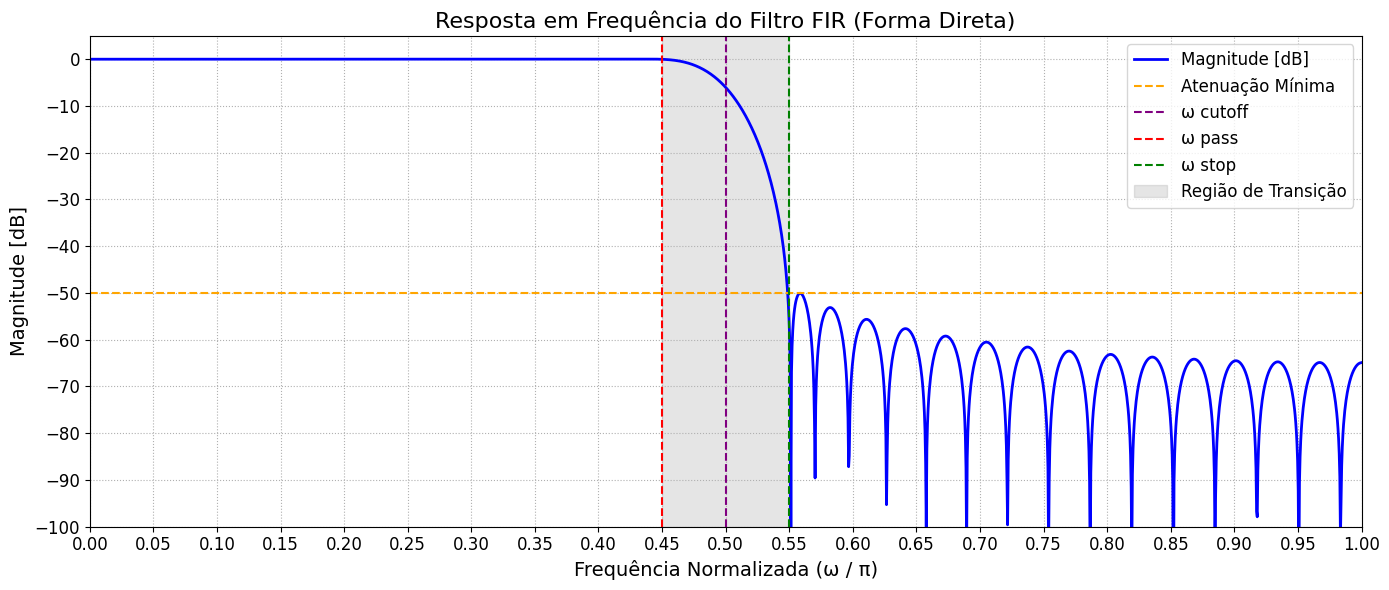

In [423]:
plt.figure(figsize=(14, 6))
plt.plot(omega_direct_norm, response_cascate_dB, color='blue', linewidth=2, label='Magnitude [dB]')
plt.title('Resposta em Frequência do Filtro FIR (Forma Direta)', fontsize=16)
plt.xlabel('Frequência Normalizada (ω / π)', fontsize=14)
plt.ylabel('Magnitude [dB]', fontsize=14)
plt.xticks(arange(0, 1.05, 0.05), fontsize=12)
plt.yticks(arange(-100, 10, 10), fontsize=12)
plt.ylim(-100, 5)
plt.xlim(0, 1.0)
plt.axhline(-50, color='orange', linestyle='--', linewidth=1.5, label='Atenuação Mínima')
plt.axvline(0.50, color='purple', linestyle='--', linewidth=1.5, label='ω cutoff')
plt.axvline(0.45, color='red', linestyle='--', linewidth=1.5, label='ω pass')
plt.axvline(0.55, color='green', linestyle='--', linewidth=1.5, label='ω stop')
plt.axvspan(0.45, 0.55, color='gray', alpha=0.2, label="Região de Transição")
plt.grid(True, which='both', linestyle=':', linewidth=0.8)
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()


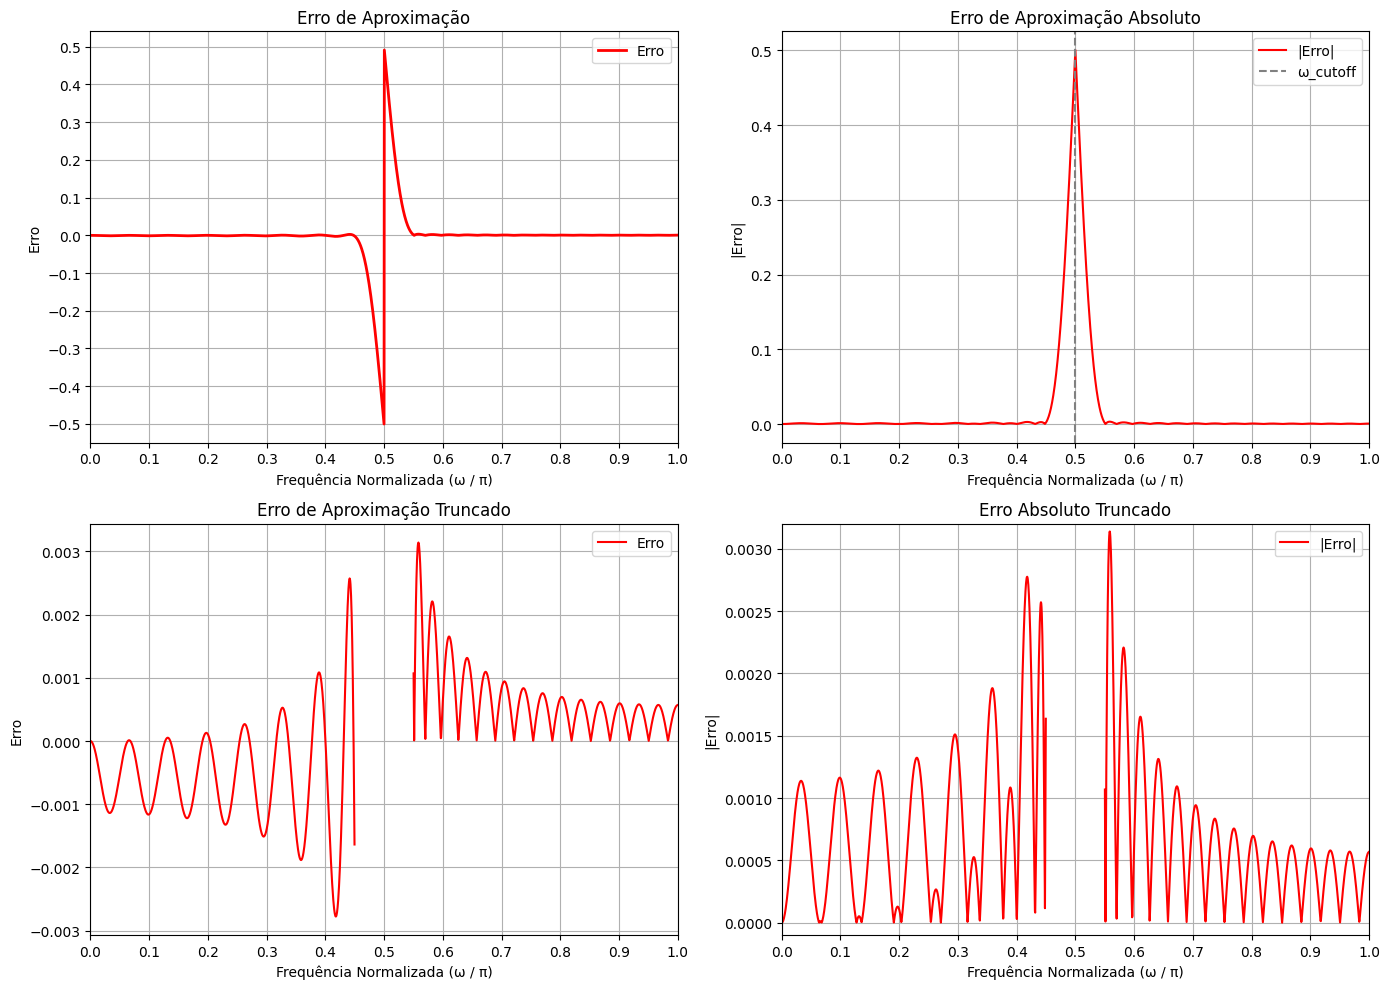

In [424]:
# Erro de aproximação = H(ω) - LPF(ω)
erro = fir_cascate_mag - lpf_ideal

# Erro de aproximação absoluto = |H(ω) - LPF(ω)|
erro_abs = abs(fir_cascate_mag - lpf_ideal)

# Arrays de bools para truncar a resposta na faixa de transição
truncate_pass = omega_cascate_norm <= w_pass / pi
truncate_stop = omega_cascate_norm >= w_stop / pi

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()  # Transforma a matriz 2x2 em um vetor de 4 elementos

# Gráfico 1: Erro de aproximação
axes[0].plot(omega_cascate_norm, erro, color='red', linewidth=2, label='Erro')
axes[0].set_title('Erro de Aproximação')
axes[0].set_xlabel('Frequência Normalizada (ω / π)')
axes[0].set_ylabel('Erro')
axes[0].set_xticks(arange(0, 1.1, 0.1))
axes[0].set_yticks(arange(-0.5, 0.6, 0.1))
axes[0].set_xlim(0, 1.0)
axes[0].grid(True)
axes[0].legend()

# Gráfico 2: Erro absoluto de aproximação
axes[1].plot(omega_cascate_norm, erro_abs, color='red', linewidth=1.5, label='|Erro|')
axes[1].axvline(w_cutoff / pi, color='grey', linestyle='--', label='ω_cutoff')
axes[1].set_title('Erro de Aproximação Absoluto')
axes[1].set_xlabel('Frequência Normalizada (ω / π)')
axes[1].set_ylabel('|Erro|')
axes[1].set_xticks(arange(0, 1.1, 0.1))
axes[1].set_xlim(0, 1.0)
axes[1].grid(True)
axes[1].legend()

# Gráfico 3: Erro de aproximação sem o pico para melhor visualização
axes[2].plot(omega_cascate_norm[truncate_pass], erro[truncate_pass], color='red', linewidth=1.5, label='Erro')
axes[2].plot(omega_cascate_norm[truncate_stop], erro[truncate_stop], color='red', linewidth=1.5)
axes[2].set_title('Erro de Aproximação Truncado')
axes[2].set_xlabel('Frequência Normalizada (ω / π)')
axes[2].set_ylabel('Erro')
axes[2].set_xlim(0, 1.0)
axes[3].set_ylim(-0.0032, 0.0032)
axes[2].set_xticks(arange(0, 1.1, 0.1))
axes[2].grid(True)
axes[2].legend()

# Gráfico 4:  Erro de aproximação absoluto sem o pico para melhor visualização
axes[3].plot(omega_cascate_norm[truncate_pass], erro_abs[truncate_pass], color='red', linewidth=1.5, label='|Erro|')
axes[3].plot(omega_cascate_norm[truncate_stop], erro_abs[truncate_stop], color='red', linewidth=1.5)
axes[3].set_title('Erro Absoluto Truncado')
axes[3].set_xlabel('Frequência Normalizada (ω / π)')
axes[3].set_ylabel('|Erro|')
axes[3].set_xlim(0, 1.0)
axes[3].set_ylim(-0.0001, 0.0032)
axes[3].set_xticks(arange(0, 1.1, 0.1))
axes[3].grid(True)
axes[3].legend()

plt.tight_layout()
plt.show()




Pela análise realizada, observa-se que, sob precisão infinita, a resposta em frequência dos filtros projetados nas formas direta e em cascata apresenta variações insignificantes. Conforme descrito por Oppenheim, Schafer e Buck (2010):

> OPPENHEIM, Alan V.; SCHAFER, Ronald W.; BUCK, John R. *Processamento de sinais em tempo discreto*. 3. ed. São Paulo: Pearson Prentice Hall, 2010.

Esse comportamento é esperado, uma vez que ambas as implementações são teoricamente equivalentes na ausência de limitações numéricas. Neste caso, a precisão de 64 bits em ponto flutuante utilizada pela linguagem de programação é suficiente para que os efeitos da quantização sejam desprezíveis.

Para avaliar os impactos da precisão numérica, os mesmos filtros serão projetados a seguir com restrições na representação dos coeficientes.
